# Multi-Classification of Chest X-Ray Images (NIH)

I will introduce a simple but extremely effective Deep Learning approach I developed to understand chest x-ray images. CXRs are the most common type of medical imaging, often 2x-10x more than other advanced imaging methods such as MRI, CT scans, PET scans.
Some reasons that CXRs are popular include: (1) lower dose of radiation; (2) lower cost; (3) it needs only less than a minute to take an image (compared with, say, an hour or more for a CT scan). As the result, CXRs are widely used as a screening tool.
CXR provides a low fidelity view that paves the way to other more sophisticated imaging methods.

The goal is to use a Machine learning model to classify x-ray images in Keras

The article on how AI is changing radiology imaging was quite interesting
https://healthitanalytics.com/news/how-artificial-intelligence-is-changing-radiology-pathology

In [45]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import seaborn as sns
import glob
import cv2

Reading the data and analysing the various factor related to deseases apart from the  real CXR images 

In [77]:
df=pd.read_csv("/Users/neeharikasinha/Documents/datascience-course/Capstone1/Data_Entry_2017.csv") 
print(df.head(3))

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  


See if there is any discrimination of gender in the complete data set. It will be good to identy the desease 

Is it relate to gender? It will be good to anaylsis all of the 14 deseases to get proder picture

In [78]:
df.groupby('Patient Gender').size()

Patient Gender
F    48780
M    63340
dtype: int64

Inn the previous data wrrangling we were able to find the outliers and this made to correc the data related to age
less than 117 which is considered to be the average age in the world ?
https://ourworldindata.org/life-expectancy
ASK: any specific link to justify 

In [81]:
#renaming the column names to aviod any error related to space in column names


In [80]:
df.rename(columns={'Image Index':'img_index','Finding Labels':'labels','Follow-up #':'follow_up','Patient ID':'pa_id',
                   'Patient Age':'pa_age','Patient Gender':'pa_gender','View Position':'view_position'}, inplace=True)
Age_below_117 = df['pa_age'] < 117 
df[Age_below_117]
tidy_df=df[Age_below_117]
tidy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112104 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   img_index                    112104 non-null  object 
 1   labels                       112104 non-null  object 
 2   follow_up                    112104 non-null  int64  
 3   pa_id                        112104 non-null  int64  
 4   pa_age                       112104 non-null  int64  
 5   pa_gender                    112104 non-null  object 
 6   view_position                112104 non-null  object 
 7   OriginalImage[Width          112104 non-null  int64  
 8   Height]                      112104 non-null  int64  
 9   OriginalImagePixelSpacing[x  112104 non-null  float64
 10  y]                           112104 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 11.1+ MB


In [49]:
Age_below_117 = df['pa_age'] < 117 
df[Age_below_117]
tidy_df=df[Age_below_117]
tidy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112104 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   img_index                    112104 non-null  object 
 1   labels                       112104 non-null  object 
 2   follow_up                    112104 non-null  int64  
 3   pa_id                        112104 non-null  int64  
 4   pa_age                       112104 non-null  int64  
 5   pa_gender                    112104 non-null  object 
 6   view_position                112104 non-null  object 
 7   OriginalImage[Width          112104 non-null  int64  
 8   Height]                      112104 non-null  int64  
 9   OriginalImagePixelSpacing[x  112104 non-null  float64
 10  y]                           112104 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 11.1+ MB


In [50]:
print(tidy_df['labels'].unique())

['Cardiomegaly' 'Cardiomegaly|Emphysema' 'Cardiomegaly|Effusion'
 'No Finding' 'Hernia' 'Hernia|Infiltration' 'Mass|Nodule' 'Infiltration'
 'Effusion|Infiltration' 'Nodule' 'Emphysema' 'Effusion' 'Atelectasis'
 'Effusion|Mass' 'Emphysema|Pneumothorax' 'Pleural_Thickening'
 'Effusion|Emphysema|Infiltration|Pneumothorax'
 'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax'
 'Effusion|Pneumonia|Pneumothorax' 'Pneumothorax'
 'Effusion|Infiltration|Pneumothorax' 'Infiltration|Mass'
 'Infiltration|Mass|Pneumothorax' 'Mass'
 'Cardiomegaly|Infiltration|Mass|Nodule'
 'Cardiomegaly|Effusion|Emphysema|Mass'
 'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax' 'Emphysema|Mass'
 'Emphysema|Mass|Pneumothorax' 'Atelectasis|Pneumothorax'
 'Cardiomegaly|Emphysema|Pneumothorax' 'Mass|Pleural_Thickening'
 'Cardiomegaly|Mass|Pleural_Thickening' 'Effusion|Infiltration|Nodule'
 'Atelectasis|Effusion|Pleural_Thickening' 'Fibrosis|Infiltration'
 'Fibrosis|Infiltration|Pleural_Thickening' 'Fibrosis'
 '

Here the data is analysed with the frequency of occurance of each named deseases. 

In [83]:
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] 

for label in disease_labels:
    tidy_df[label] = tidy_df['labels'].map(lambda result: 1.0 if label in result else 0)
tidy_df.head()

/Users/neeharikasinha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,img_index,labels,follow_up,pa_id,pa_age,pa_gender,view_position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [84]:
unique_labels = tidy_df[disease_labels].sum().sort_values(ascending= False) 
print(unique_labels[:5]) 

Infiltration    19891.0
Effusion        13316.0
Atelectasis     11558.0
Nodule           6331.0
Mass             5779.0
dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x1a3b596810>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
  <a list of 14 Text xticklabel objects>))

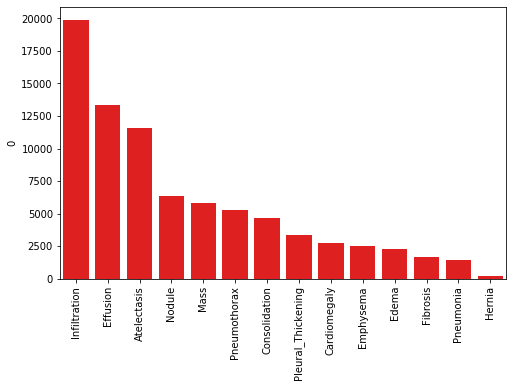

In [85]:
plt.figure(figsize=(8,5)) 
unique_labels_df = unique_labels.to_frame() 
sns.barplot(x = unique_labels_df.index[::], y= 0, data = unique_labels_df[::], color = "red"), plt.xticks(rotation = 90) # visualize results graphically

We need to find a trend or a algorithm which defines an image having Cardiomegaly. The size of the heart can be measured through image analysis.
Plan to answer these questions through Convolution Neural Network 

In [86]:
tidy_df['Cardiomegaly'] = np.where(tidy_df.loc[:,'labels'].str.contains('Cardiomegaly'),1,0)
print(tidy_df.head())

          img_index                  labels  follow_up  pa_id  pa_age  \
0  00000001_000.png            Cardiomegaly          0      1      58   
1  00000001_001.png  Cardiomegaly|Emphysema          1      1      58   
2  00000001_002.png   Cardiomegaly|Effusion          2      1      58   
3  00000002_000.png              No Finding          0      2      81   
4  00000003_000.png                  Hernia          0      3      81   

  pa_gender view_position  OriginalImage[Width  Height]  \
0         M            PA                 2682     2749   
1         M            PA                 2894     2729   
2         M            PA                 2500     2048   
3         M            PA                 2500     2048   
4         F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Edema  Emphysema  Fibrosis  Effusion  \
0                        0.143  ...    0.0        0.0       0.0       0.0   
1                        0.143  ...    0.0        1.

/Users/neeharikasinha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


here I just tried to print the images to have a look at the CXR image 

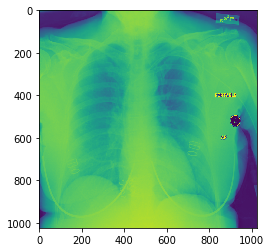

In [87]:
images = plt.imread('/Users/neeharikasinha/Documents/datascience-course/Capstone1/normal_img/00000005_001.png')
plt.imshow(images)

0 Normal images


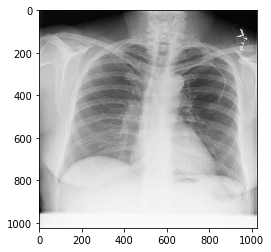

1 Normal images


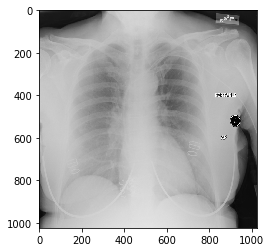

2 Normal images


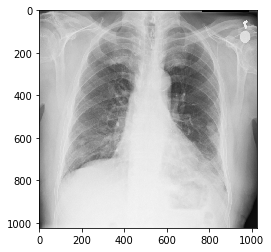

In [74]:
#fig1, f1_axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True)
images = [cv2.imread(file) for file in glob.glob("/Users/neeharikasinha/Documents/datascience-course/Capstone1/normal_img/*.png")]
for i,img in enumerate(images):
  print (i, 'Normal images')
  if i<=3:
    
    plt.imshow(img)
    plt.show()
  else: 
    break 

0


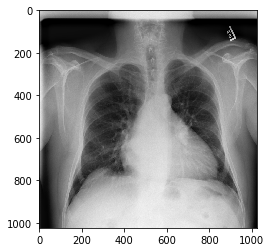

1


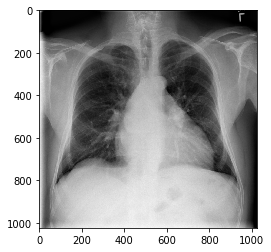

2


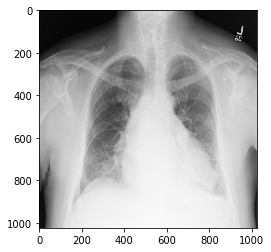

3


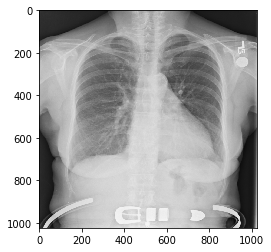

In [75]:
images = [cv2.imread(file) for file in glob.glob("/Users/neeharikasinha/Documents/datascience-course/Capstone1/cardiomegaly_img/*.png")]
for i,img in enumerate(images):
  print (i)
  if i<=3:
    plt.imshow(img)
    plt.show()
  else: 
    break 